In [1]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean as cmo
import os,sys,fnmatch,time
import numpy as np
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
from matplotlib.ticker import MultipleLocator
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import animation
from salishsea_tools.nc_tools import scDataset
from matplotlib import ticker
from matplotlib import colors
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
import math
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import sys
sys.path.append('/ocean/imachuca/Canyons/analysis_mackenzie_canyon/notebooks/general_circulation/')
import general_functions

import pandas as pd
from io import StringIO
import csv

import gsw
from gsw import conversions

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

## Plot from thesis

In [3]:
lw, ms, fs_numb, fs_str = 6, 12, 25, 30
def thesis_fig():
    
    real_file = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/bathymetry/NEMO_files/realistic/real_bathy_for_agrif.nc')
    coords_file = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/coordinates/NEMO_files/coords_for_agrif.nc')
    y,x = slice(1,-1,None), slice(1,-1,None)
    
    # --------------------------------------------------------

    nav_lat = coords_file['nav_lat'][y, x]
    nav_lon = coords_file['nav_lon'][y, x]
    real = real_file['Bathymetry'][y, x]

    coords_ctrl = [-139.93484321666668, 70.55863003333333]
    coords_eval = [-139.60871666666668, 70.70343333333334]
    lat_nut, lon_nut, time_nut = np.loadtxt('../thesis/files/nutrient_info.out', delimiter=",")
    salt_nut, PO4, NO3 = np.loadtxt('../thesis/files/nutrient_prof.out', delimiter=",")
    
    # --------------------------------------------------------

    fig, axm = plt.subplots(1,1,figsize=(15,10))

    axm.tick_params(direction='in', length=4, color='k', labelsize=fs_numb)
    axm.xaxis.set_ticks_position('none') 
    axm.yaxis.set_ticks_position('none')
    for axis in ['top','bottom','left','right']:
        axm.spines[axis].set_linewidth(2)

    axm.contour(nav_lon, nav_lat, real, levels = np.arange(0, 500, 20), colors='k', linestyle='-', alpha=0.5)
    w=1/math.cos(math.radians(70.0))
    axm.set_aspect(w)
    axm.set_xlim([-141.5, -136.2])
    axm.set_ylim([68.9, 71.1])
    s1 = axm.scatter(coords_ctrl[0], coords_ctrl[1], c='steelblue', s=300, label='control stratification')
    s2 = axm.scatter(coords_eval[0], coords_eval[1], c='mediumseagreen', s=300, label='evaluation stratification')
#     s3 = axm.scatter(-1*lon_nut, lat_nut, c='orangered', s=300, label='nitrate concentration')

    axm.text(coords_ctrl[0], coords_ctrl[1], 'control', ha='center', fontsize=fs_numb*0.9)
    axm.text(coords_eval[0], coords_eval[1], 'evaluation', ha='center', fontsize=fs_numb*0.9)
#     axm.text(-140.5, 70-0.12, 'nitrate', ha='center', fontsize=fs_numb*0.9)
#     axm.text(-138.5, 70-0.12, 'nitrate', ha='center', fontsize=fs_numb*0.9)
#     axm.text(-139.5, 71-0.12, 'nitrate', ha='center', fontsize=fs_numb*0.9)

    axm.yaxis.set_ticks([69, 70, 71])
    axm.xaxis.set_ticks([-137, -140])
    axm.set_yticklabels([str(x)+'$\degree$N' for x in axm.get_yticks().tolist()])
    axm.set_xticklabels([str(abs(x))+'$\degree$W' for x in axm.get_xticks().tolist()])
    axm.set_xlabel('Longitude', fontsize=fs_str, labelpad=5)
    axm.set_ylabel('Latitude', fontsize=fs_str, labelpad=5)

    fig.patch.set_facecolor('white')

    fig.tight_layout(w_pad=2.0, h_pad=1)
    
    return fig, axm

## Data files for both Mackenzie River and historic runs

https://www.nodc.noaa.gov/OC5/SELECT/dbsearch/dbsearch.html

In [4]:
def get_attributes(filename):
    df_attrib = pd.read_csv(filename, error_bad_lines=False, skiprows=[0], header=None, warn_bad_lines=False)
    latitude = df_attrib.iloc[3][2]
    longitude = df_attrib.iloc[4][2]
    year = int(df_attrib.iloc[5][2])
    month = int(df_attrib.iloc[6][2])
    return latitude, longitude, year, month

def get_profiles(filename):
    df_data = pd.read_csv(filename, skiprows=np.arange(23), header=None, warn_bad_lines=False)
    depths = df_data[1]
    temperature = df_data[4]
    salinity = df_data[7]
    return depths, temperature, salinity

In [5]:
filenames = ['CTD_1974.csv', 'CTD_1979.csv', 'CTD_1984.csv', 'CTD_1985.csv', 'CTD_2012.csv']

In [6]:
attributes = np.full([len(filenames), 5], np.nan)

for filename, n in zip(filenames, np.arange(len(filenames))):
    
    latitude, longitude, year, month = get_attributes(filename)
        
    #print(filename, year, month, latitude, longitude)
   
    attributes[n, 0] = year
    attributes[n, 1] = month
    attributes[n, 2] = latitude
    attributes[n, 3] = longitude
    
    df_data = pd.read_csv(filename, skiprows=np.arange(23), header=None, warn_bad_lines=False)
    depths = df_data[1]
    len_dep = len(depths)
    max_dep = np.round(depths[len_dep-2],1)
    
    #print(len_dep, max_dep)
    
    attributes[n, 4] = max_dep

# Locations

In [7]:
#colors = ['#6A1317', '#9E2A21', '#D68078', '#EA8C55', '#12355B']
colors = ['#E03535', '#FC880C', '#FCC455', '#B38CB4', '#195271']

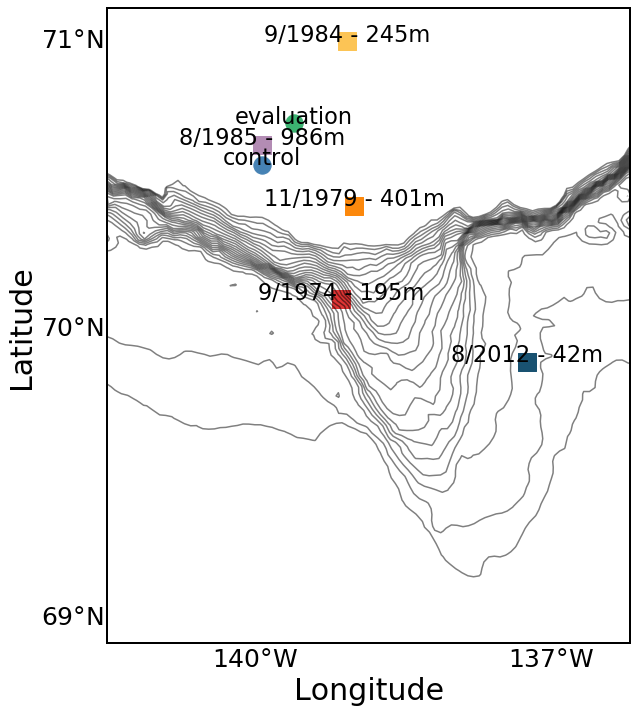

In [8]:
fig, axm = thesis_fig()
for filename, c, n in zip(filenames, colors, np.arange(len(filenames))):
    #print(attributes[n, 2], attributes[n, 3])
    axm.scatter(attributes[n, 3], attributes[n, 2], c=c, s=300, marker='s')
    label_new = str(int(attributes[n, 1]))+'/'+str(int(attributes[n, 0]))+' - '+str(int(attributes[n, 4]))+'m'
    axm.text(attributes[n, 3], attributes[n, 2], label_new, ha='center', fontsize=fs_numb*0.9)

# Profiles

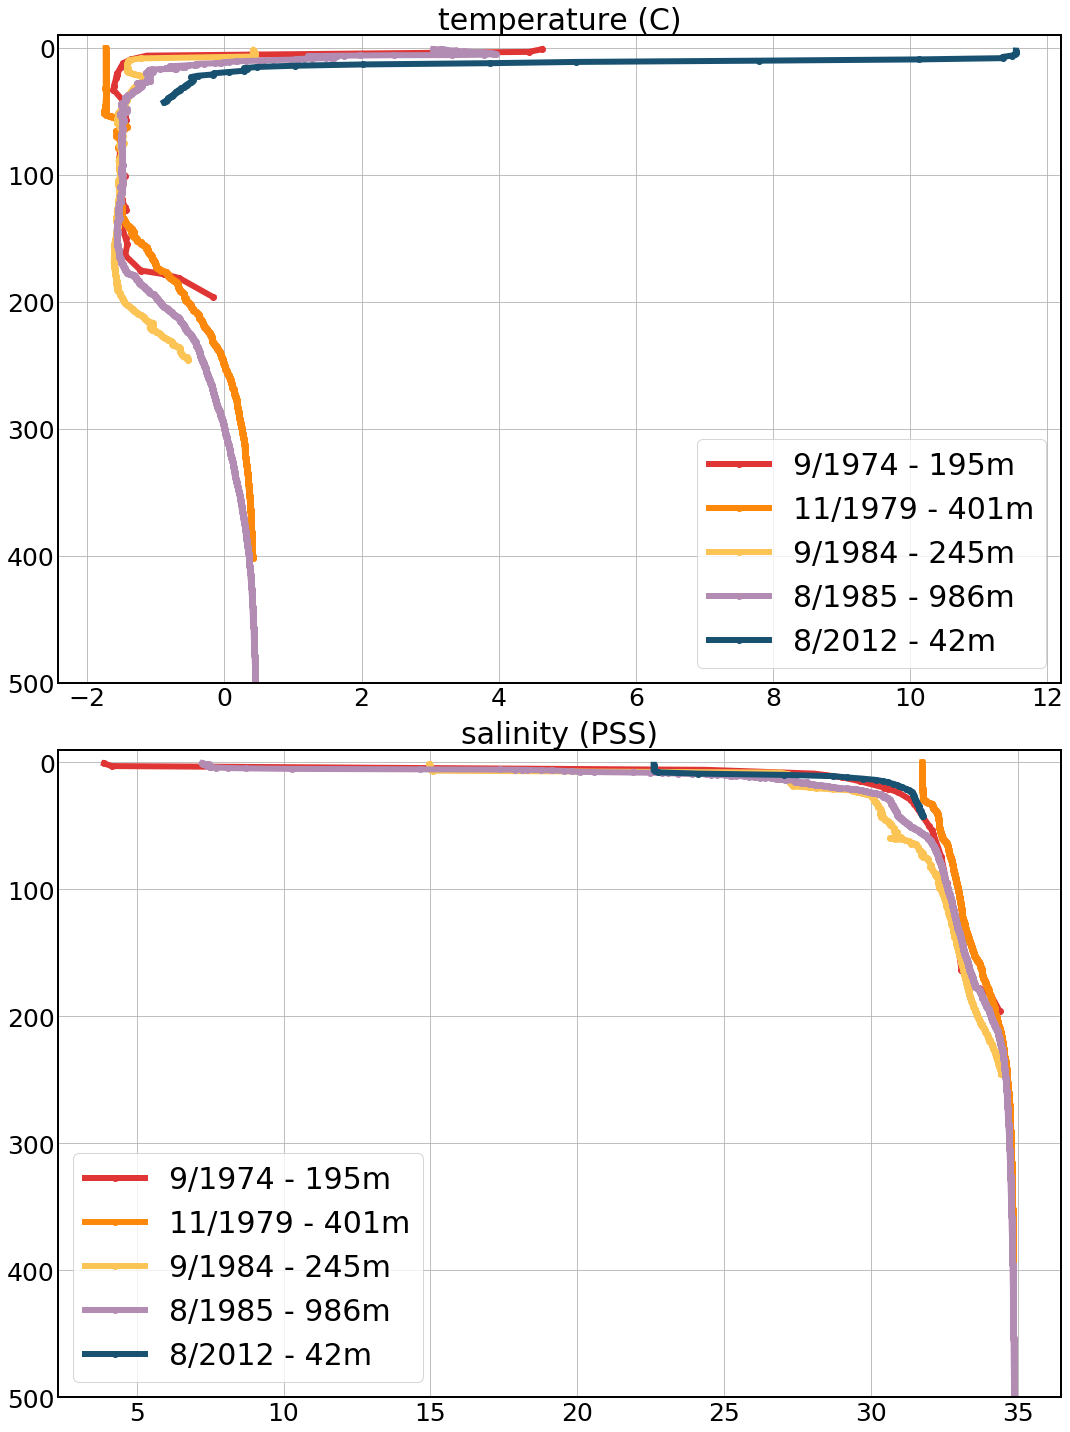

In [9]:
fig, (axt, axs) = plt.subplots(2,1,figsize=(15, 20))

for ax in [axt, axs]:
    ax.tick_params(direction='in', length=4, color='k', labelsize=fs_numb)
    ax.xaxis.set_ticks_position('none') 
    ax.yaxis.set_ticks_position('none')
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2)
    ax.set_ylim([500, -10])
    ax.grid()
    
for filename, c, n in zip(filenames, colors, np.arange(len(filenames))):
    
    depths, temperature, salinity = get_profiles(filename)

    label_new = str(int(attributes[n, 1]))+'/'+str(int(attributes[n, 0]))+' - '+str(int(attributes[n, 4]))+'m'
    axt.plot(temperature, depths, c=c, linewidth=lw, label=label_new, marker='o')
    axs.plot(salinity, depths, c=c, linewidth=lw, label=label_new, marker='o')
    
    axt.legend(loc=4, fontsize=fs_str)
    axs.legend(loc=3, fontsize=fs_str)

axt.set_title('temperature (C)', fontsize=fs_str)
axs.set_title('salinity (PSS)', fontsize=fs_str)
fig.patch.set_facecolor('white')
fig.tight_layout(w_pad=2.0, h_pad=1)

# Control and Evaluation

In [10]:
votemper_c = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/conditions/NEMO_files/temperature/temperature_for_agrif.nc')['votemper'][0, :, 0, 0]
vosaline_c = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/conditions/NEMO_files/salinity/salinity_for_agrif.nc')['vosaline'][0, :, 0, 0]

votemper_e = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/conditions/NEMO_files/temperature/temperatureAW_for_agrif.nc')['votemper'][0, :, 0, 0]
vosaline_e = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/conditions/NEMO_files/salinity/salinityAW_for_agrif.nc')['vosaline'][0, :, 0, 0]

dirname='/ocean/imachuca/Canyons/results_mackenzie/extended_domain/ideal_base/'
fname = "1_MCKNZ_1h_20170101_201701*"
filesT = general_functions.get_files(dirname, fname, 'grid_T')
with scDataset(filesT) as dsT:
    deptht = dsT.variables['deptht'][:]

# Historic and River

In [11]:
def plot_comparisons(filename_historic, filename_river, c_historic):

    latitude_h, longitude_h, year_h, month_h = get_attributes(filename_historic)
    depths_h, temperature_h, salinity_h = get_profiles(filename_historic)

    latitude_r, longitude_r, year_r, month_r = get_attributes(filename_river)
    depths_r, temperature_r, salinity_r = get_profiles(filename_river)

    p = 10

    salinity_abs_h = conversions.SA_from_SP(salinity_h, p, longitude_h, latitude_h)
    salinity_abs_r = conversions.SA_from_SP(salinity_r, p, longitude_r, latitude_r)

    fig, (axt, axs) = plt.subplots(1, 2, figsize=(20,10))

    for ax in [axt, axs]:
        ax.tick_params(direction='in', length=4, color='k', labelsize=fs_numb)
        ax.xaxis.set_ticks_position('none') 
        ax.yaxis.set_ticks_position('none')
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)
        ax.set_ylim([500, -10])
        ax.grid()

    axt.plot(votemper_c, deptht, c='steelblue', lw=lw, linestyle='-', label='control')
    axs.plot(vosaline_c, deptht, c='steelblue', lw=lw, linestyle='-', label='control')

    axt.plot(votemper_e, deptht, c='mediumseagreen', lw=lw, linestyle='-', label='evaluation')
    axs.plot(vosaline_e, deptht, c='mediumseagreen', lw=lw, linestyle='-', label='evaluation')

    axs.plot(salinity_abs_h, depths_h, c=c_historic, lw=lw, label='historic: '+str(filename_historic))
    axs.plot(salinity_abs_r, depths_r, c='#195271', lw=lw, label='river')

    axt.plot(temperature_h, depths_h, c=c_historic, lw=lw, label='historic: '+str(filename_historic))
    axt.plot(temperature_r, depths_r, c='#195271', lw=lw, label='river')

    axt.legend(loc=4, fontsize=fs_str)
    axs.legend(loc=3, fontsize=fs_str)

    axt.set_title('temperature (C)', fontsize=fs_str)
    axs.set_title('salinity (g/kg)', fontsize=fs_str)
    fig.patch.set_facecolor('white')
    fig.tight_layout()
    plt.subplots_adjust(top=0.85, wspace=0.11, hspace=0.5)
    
    return fig

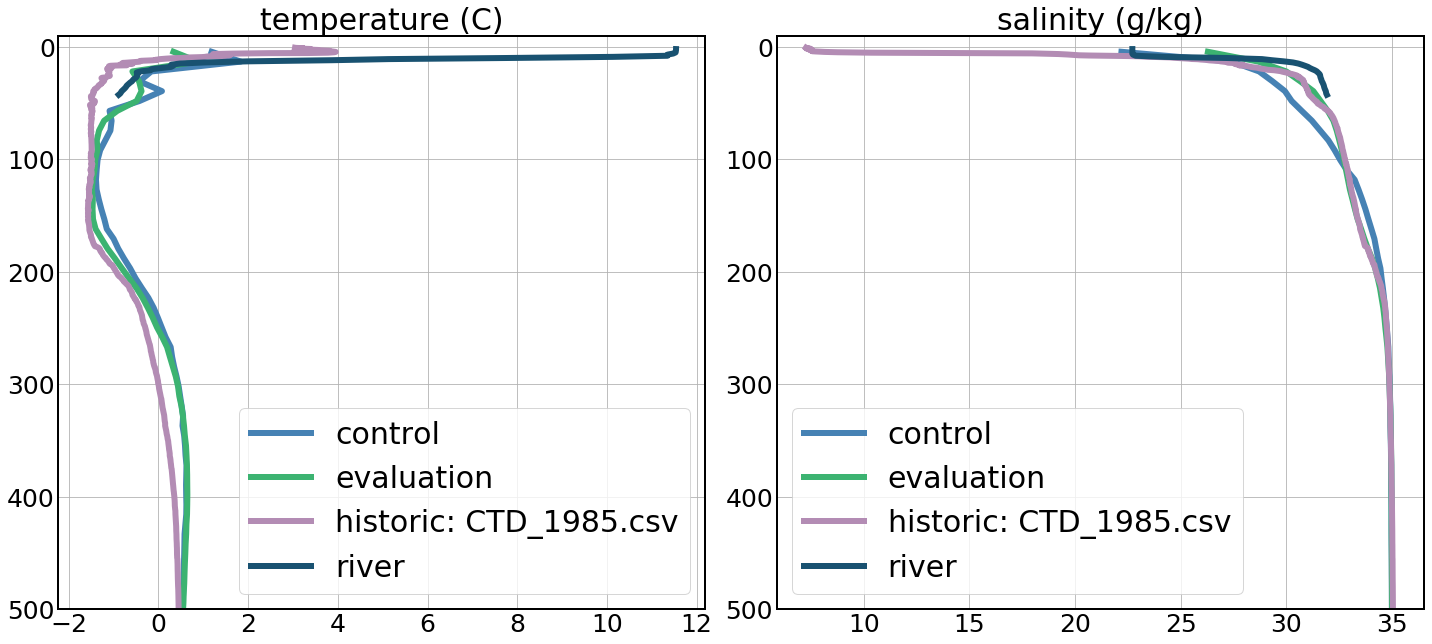

In [12]:
filename_historic = 'CTD_1985.csv'
filename_river = 'CTD_2012.csv'
fig = plot_comparisons(filename_historic, filename_river, '#B38CB4')

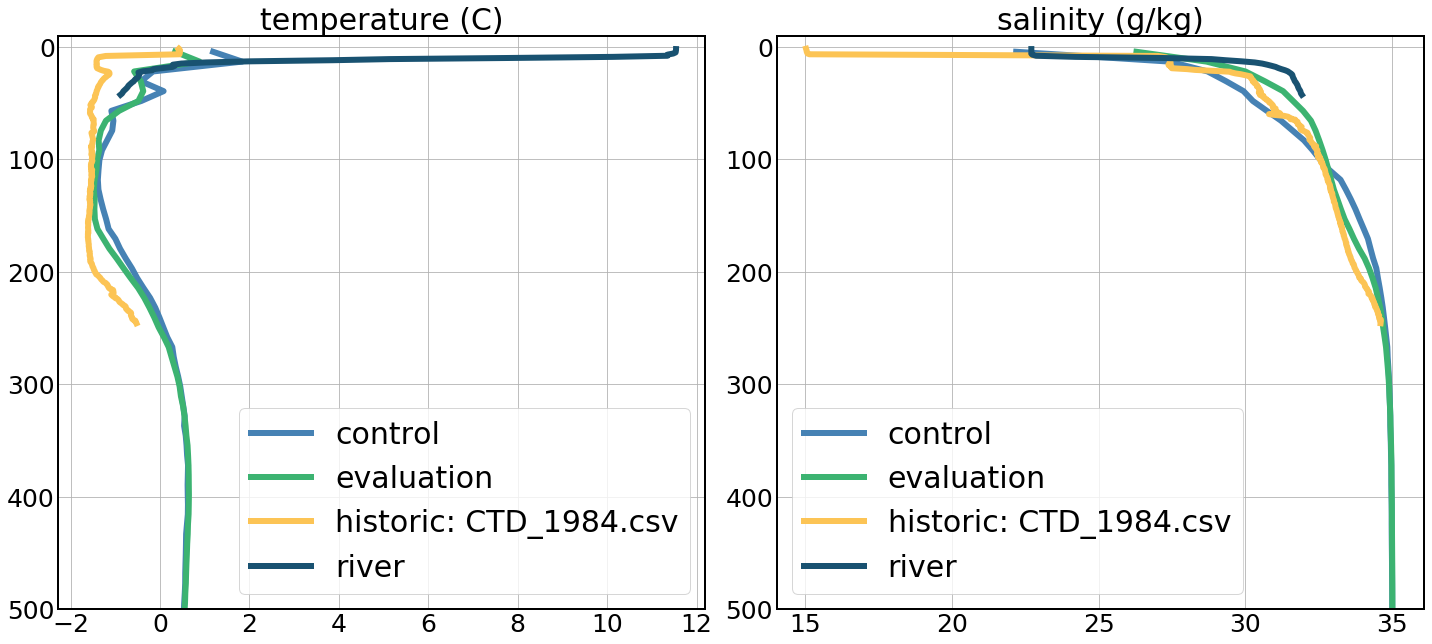

In [13]:
filename_historic = 'CTD_1984.csv'
filename_river = 'CTD_2012.csv'
fig = plot_comparisons(filename_historic, filename_river, '#FCC455')

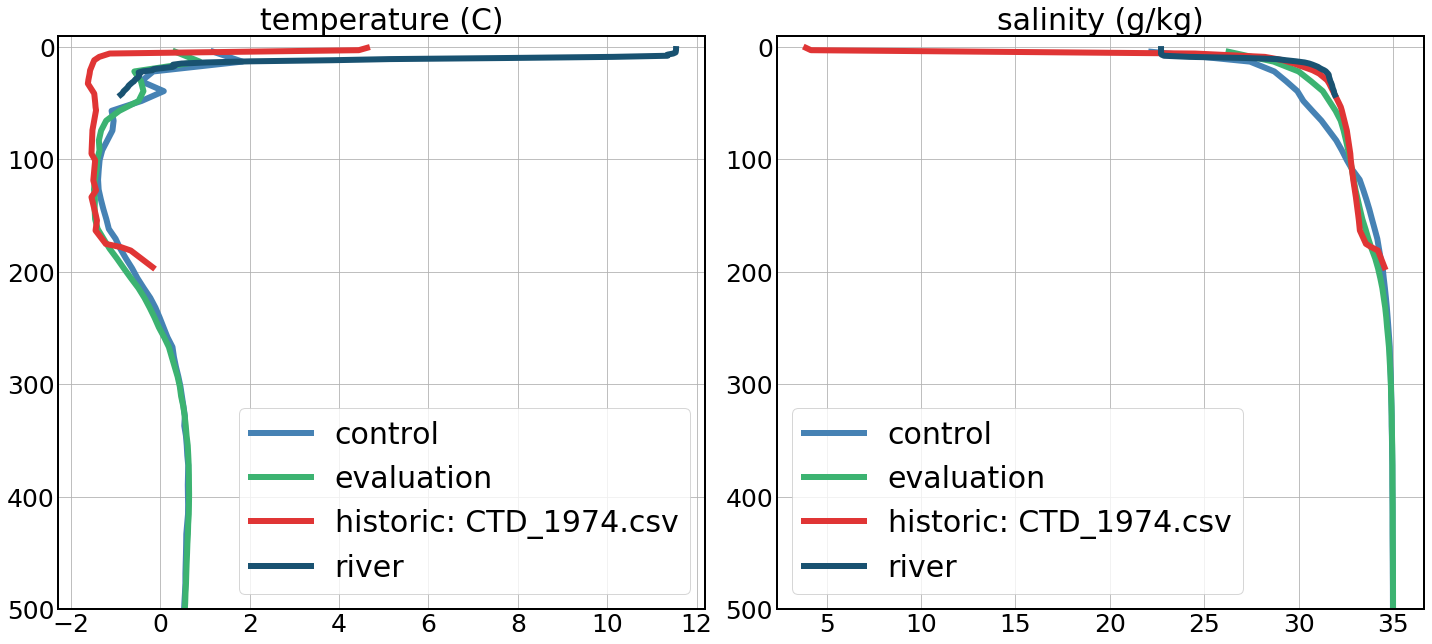

In [14]:
filename_historic = 'CTD_1974.csv'
filename_river = 'CTD_2012.csv'
fig = plot_comparisons(filename_historic, filename_river, '#E03535')